In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import morphology

def show(img, title=''):
    if img is None:
        print(f"{title} → Image is None")
        return
    if img.ndim == 3:
        img2 = img[..., ::-1]  # BGR to RGB
    else:
        img2 = img
    plt.figure(figsize=(8,6))
    plt.title(title)
    plt.axis("off")
    plt.imshow(img2, cmap="gray")
    plt.show()


In [2]:
dog_path= cv2.imread('dog.jpeg')
bg_path= cv2.imread('bg.jpeg')

Using -> c:\Users\reddy\Downloads\edge-a\dog.jpeg and c:\Users\reddy\Downloads\edge-a\bg.jpeg
Loaded? dog: True , bg: True


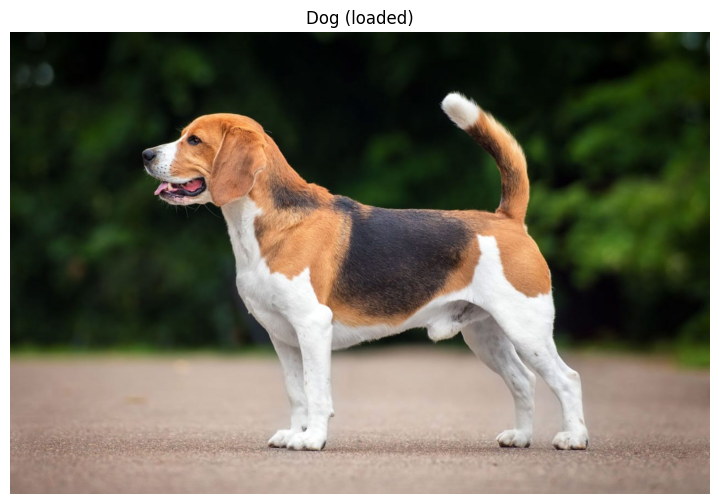

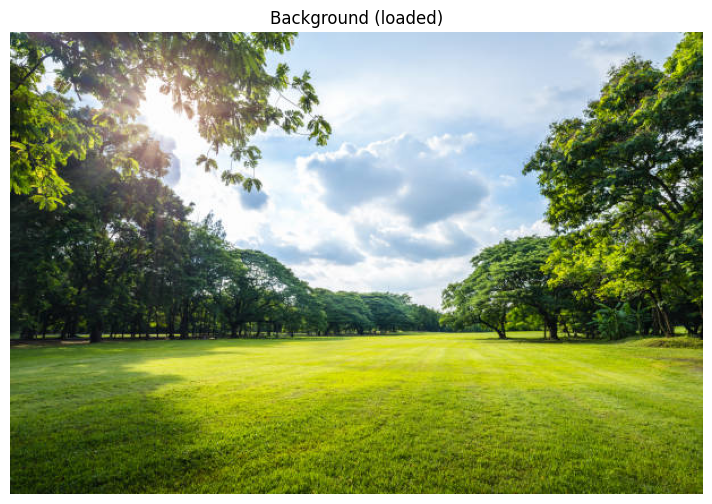

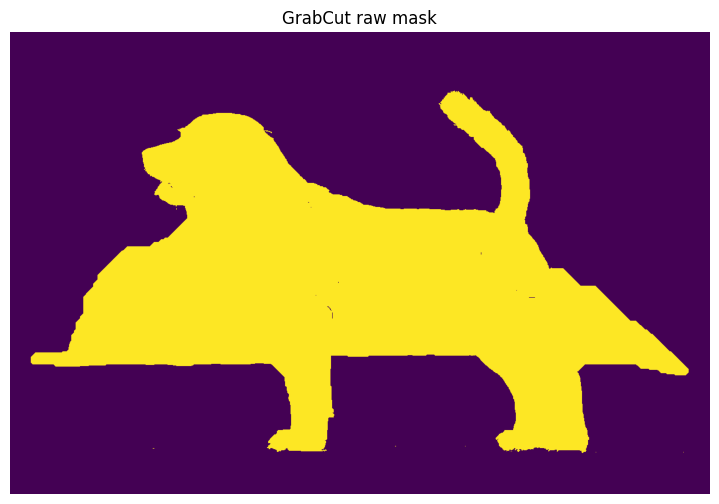

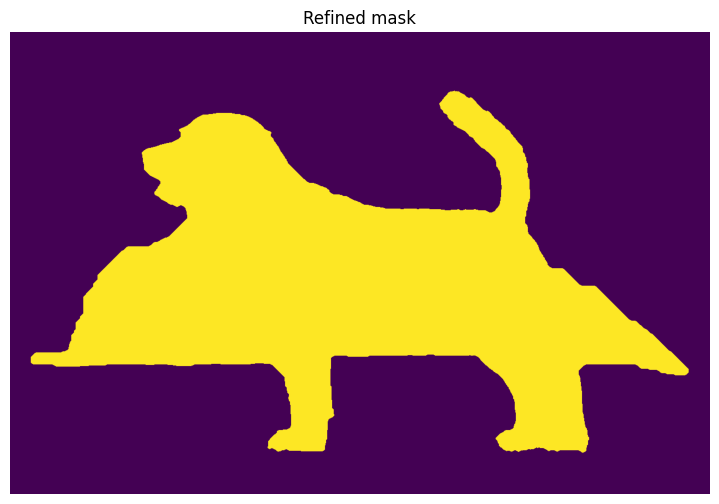

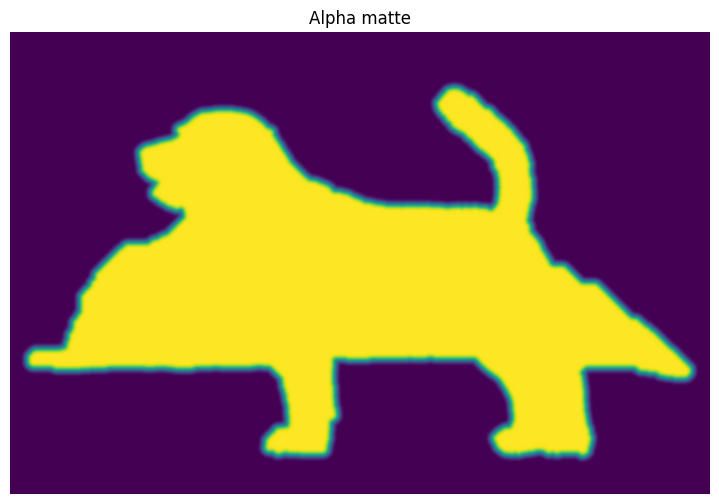

Saved result_seamless_clone.jpg


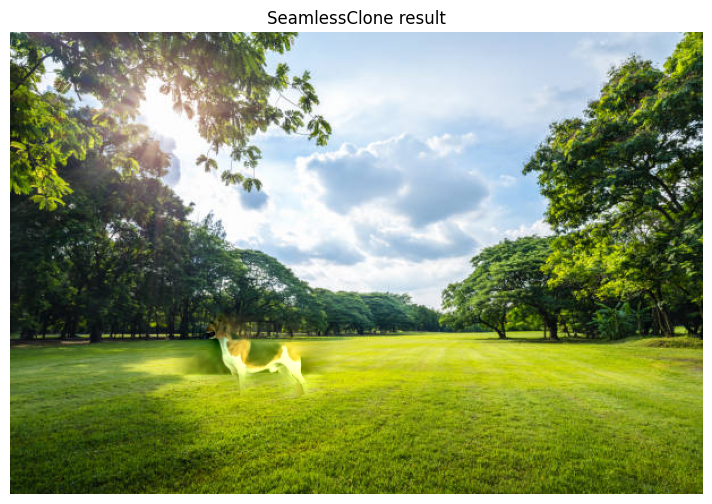

Saved mask_refined.png and alpha_matte.png


In [3]:
#full pipeline
import os, cv2, numpy as np
from skimage import morphology
import matplotlib.pyplot as plt

#helper to show images
def show(img, title=''):
    if img is None:
        print(title, "-> Image is None")
        return
    if img.ndim==3:
        img2 = img[..., ::-1]
    else:
        img2 = img
    plt.figure(figsize=(10,6)); plt.title(title); plt.axis('off'); plt.imshow(img2); plt.show()

files = [f for f in sorted(os.listdir('.')) if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.tiff'))]

dog_file = next((f for f in files if 'dog' in f.lower()), None)
bg_file  = next((f for f in files if 'bg' in f.lower() or 'background' in f.lower()), None)

dog_path = os.path.abspath(dog_file)
bg_path  = os.path.abspath(bg_file)
print("Using ->", dog_path, "and", bg_path)

dog = cv2.imread(dog_path)
bg  = cv2.imread(bg_path)
print("Loaded? dog:", dog is not None, ", bg:", bg is not None)
show(dog, "Dog (loaded)")
show(bg, "Background (loaded)")

#grabcut
h,w = dog.shape[:2]
mask = np.zeros((h,w), np.uint8)
bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)
rect = (int(w*0.03), int(h*0.02), int(w*0.94), int(h*0.96))
cv2.grabCut(dog, mask, rect, bgdModel, fgdModel, 6, cv2.GC_INIT_WITH_RECT)
grabcut_mask = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
show(grabcut_mask*255, "GrabCut raw mask")

#refine
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
m = cv2.morphologyEx(grabcut_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
m = cv2.morphologyEx(m, cv2.MORPH_OPEN, kernel, iterations=1)
m_bool = morphology.remove_small_objects(m.astype(bool), min_size=300)
m_bool = morphology.remove_small_holes(m_bool, area_threshold=500)
mask_refined = (m_bool.astype(np.uint8) * 255).astype(np.uint8)
show(mask_refined, "Refined mask")

#alpha matte
dist = cv2.distanceTransform((mask_refined==0).astype(np.uint8), cv2.DIST_L2, 5)
edge_width = int(max(3, min(h,w) * 0.02))
alpha_feather = np.clip(1 - (dist / edge_width), 0.0, 1.0)
alpha = cv2.GaussianBlur(alpha_feather, (15,15), 0)
show((alpha*255).astype(np.uint8), "Alpha matte")

#resize dog to fit background
bg_h, bg_w = bg.shape[:2]
target_w = int(bg_w * 0.25)
scale = target_w / w
new_w = max(1, int(w * scale)); new_h = max(1, int(h * scale))
dog_r = cv2.resize(dog, (new_w, new_h), interpolation=cv2.INTER_AREA)
alpha_r = cv2.resize((alpha*255).astype(np.uint8), (new_w, new_h), interpolation=cv2.INTER_LINEAR).astype(np.uint8)
mask_clone = (alpha_r > 150).astype(np.uint8) * 255

#paste center
center = (int(bg_w * 0.35), int(bg_h * 0.7))

#try seamlessClone
try:
    result = cv2.seamlessClone(dog_r, bg, mask_clone, center, cv2.NORMAL_CLONE)
    out_path = "result_seamless_clone.jpg"
    cv2.imwrite(out_path, result)
    print("Saved", out_path)
    show(result, "SeamlessClone result")
except Exception as e:
    print("seamlessClone failed:", e)
    #fallback alpha blend
    composite = bg.copy()
    x = center[0] - new_w//2; y = center[1] - new_h//2
    x1, y1 = max(0,x), max(0,y); x2, y2 = min(bg_w, x+new_w), min(bg_h, y+new_h)
    sx1 = x1 - x; sy1 = y1 - y; sx2 = sx1 + (x2-x1); sy2 = sy1 + (y2-y1)
    roi_bg = composite[y1:y2, x1:x2].astype(np.float32)
    roi_fg = dog_r[sy1:sy2, sx1:sx2].astype(np.float32)
    alpha3 = np.dstack([alpha_r.astype(np.float32)/255.0]*3)[sy1:sy2, sx1:sx2]
    blended = (roi_fg * alpha3 + roi_bg * (1-alpha3)).astype(np.uint8)
    composite[y1:y2, x1:x2] = blended
    out_path = "result_alpha_blend.jpg"
    cv2.imwrite(out_path, composite)
    print("Saved", out_path)
    show(composite, "Alpha blend result")

cv2.imwrite("mask_refined.png", mask_refined)
cv2.imwrite("alpha_matte.png", (alpha*255).astype(np.uint8))
print("Saved mask_refined.png and alpha_matte.png")


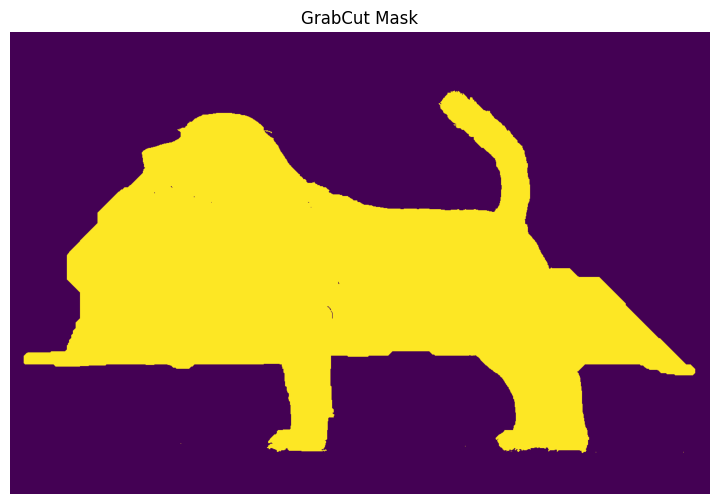

In [4]:
#Prepare mask
h, w = dog.shape[:2]
mask = np.zeros((h, w), np.uint8)
bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)

#rectangle covering 96% of image
rect = (int(w*0.02), int(h*0.02), int(w*0.96), int(h*0.96))

cv2.grabCut(dog, mask, rect, bgdModel, fgdModel, 6, cv2.GC_INIT_WITH_RECT)

grabcut_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
show(grabcut_mask * 255, "GrabCut Mask")


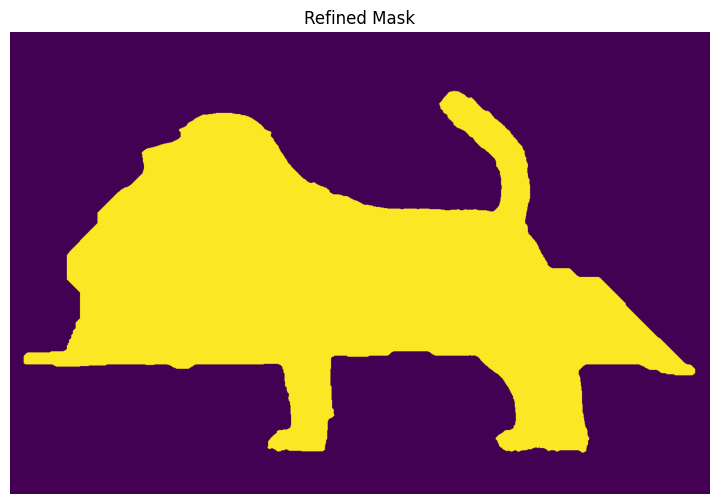

In [5]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))

m = cv2.morphologyEx(grabcut_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
m = cv2.morphologyEx(m, cv2.MORPH_OPEN, kernel, iterations=1)

m_bool = morphology.remove_small_objects(m.astype(bool), min_size=300)
m_bool = morphology.remove_small_holes(m_bool, area_threshold=500)

mask_refined = (m_bool.astype(np.uint8) * 255).astype(np.uint8)
show(mask_refined, "Refined Mask")

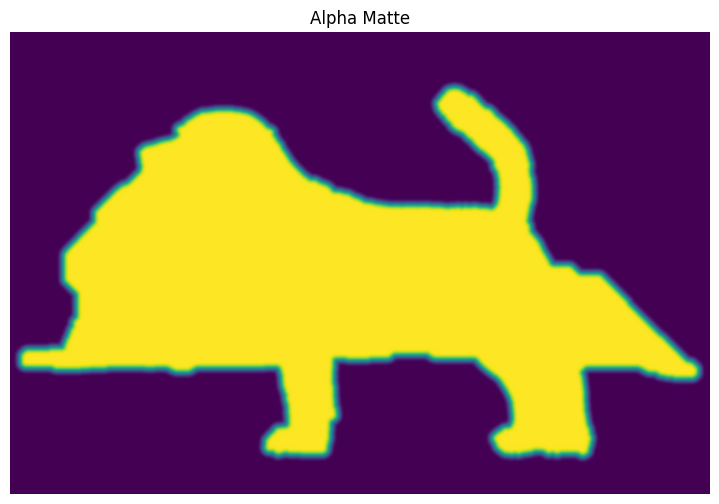

In [6]:
dist = cv2.distanceTransform((mask_refined == 0).astype(np.uint8), cv2.DIST_L2, 5)
edge_width = int(max(5, min(h, w) * 0.02))
alpha_feather = np.clip(1 - dist / edge_width, 0.0, 1.0)

alpha = cv2.GaussianBlur(alpha_feather, (15,15), 0)
show((alpha * 255).astype(np.uint8), "Alpha Matte")

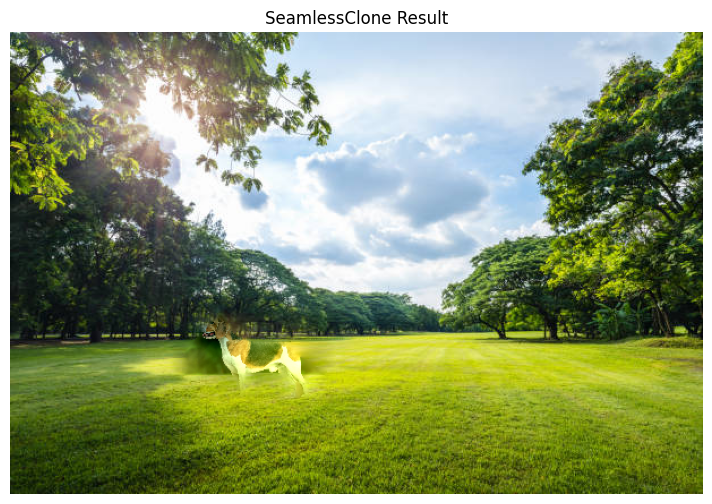

Saved result_seamless.jpg


In [7]:
bg_h, bg_w = bg.shape[:2]

target_w = int(bg_w * 0.25)
scale = target_w / w

new_w = int(w * scale)
new_h = int(h * scale)

dog_r = cv2.resize(dog, (new_w, new_h))
alpha_r = cv2.resize((alpha*255).astype(np.uint8), (new_w, new_h))

mask_clone = (alpha_r > 150).astype(np.uint8) * 255

#paste position
center = (int(bg_w*0.35), int(bg_h*0.7))

try:
    result = cv2.seamlessClone(dog_r, bg, mask_clone, center, cv2.NORMAL_CLONE)
    cv2.imwrite("result_seamless.jpg", result)
    show(result, "SeamlessClone Result")
    print("Saved result_seamless.jpg")

except Exception as e:
    print("seamlessClone failed:", e)
    comp = bg.copy()
    x = center[0] - new_w//2
    y = center[1] - new_h//2

    x1, y1 = max(0, x), max(0, y)
    x2, y2 = min(bg_w, x+new_w), min(bg_h, y+new_h)

    sx1 = x1 - x
    sy1 = y1 - y
    sx2 = sx1 + (x2-x1)
    sy2 = sy1 + (y2-y1)

    roi_bg = comp[y1:y2, x1:x2].astype(np.float32)
    roi_fg = dog_r[sy1:sy2, sx1:sx2].astype(np.float32)

    alpha3 = np.dstack([(alpha_r/255)]*3)[sy1:sy2, sx1:sx2]

    blend = (roi_fg * alpha3 + roi_bg * (1 - alpha3)).astype(np.uint8)
    comp[y1:y2, x1:x2] = blend

    cv2.imwrite("result_blend.jpg", comp)
    show(comp, "Alpha Blend Result")
    print("Saved result_blend.jpg")